In [ ]:
from google.colab import files
files.upload()

Saving incidents_sample.csv to incidents_sample.csv
Saving emergencies_facilities.csv to emergencies_facilities.csv
Saving roads.csv to roads.csv
Saving locations.csv to locations.csv


{'incidents_sample.csv': b'incident_id,location_id,emergency_type,severity_level,description\nINC1,L1,Medical,High,Heart attack reported at Connaught Place\nINC2,L9,Medical,Medium,Injury reported at Sarojini Nagar Market\nINC3,L15,Medical,Low,Dehydration case at Lodhi Garden\nINC4,L11,Medical,Medium,Road accident injuries at Rajouri Garden\nINC5,L4,Fire,High,Fire near India Gate circle\nINC6,L10,Fire,Medium,Shop fire reported in Lajpat Nagar Market\nINC7,L20,Fire,High,Residential building fire in Mayur Vihar\nINC8,L12,Fire,Low,Electrical fire near Akshardham\nINC9,L7,Medical,Medium,Fall injury at Qutub Minar\nINC10,L8,Medical,Low,Minor injury at Lotus Temple\nINC11,L5,Fire,Medium,Small fire on railway platform\nINC12,L6,Medical,Medium,Passenger emergency at Nizamuddin Station\nINC13,L13,Medical,High,Medical emergency at Dwarka Sector 21 Metro\nINC14,L14,Fire,Low,Vehicle fire near Dhaula Kuan\nINC15,L3,Medical,High,Critical emergency at Safdarjung Hospital entry\n',
 'emergencies_facili

# Emergency Response Dispatch System – Part 2
## Emergency Dispatch Optimization & Analysis

### Objective
To extend the city emergency network by integrating emergency facilities,
incident routing, dispatch optimization, analytics, and visualization using
advanced Data Structures and Algorithms (DSA).

In [34]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import heapq

 Load Datasets

In [35]:
locations = pd.read_csv("locations.csv")
roads = pd.read_csv("roads.csv")
facilities = pd.read_csv("emergencies_facilities.csv")
incidents = pd.read_csv("incidents_sample.csv")

In [36]:
display(facilities.head())
display(incidents.head())

,location_id,facility_type,name,capacity_level
0,L2,Hospital,AIIMS Emergency,High
1,L3,Hospital,Safdarjung Trauma Centre,High
2,L5,Hospital,Railway Station Medical Unit,Low
3,L17,Hospital,IGI Airport Medical Unit,Low
4,L9,FireStation,Sarojini Nagar Fire Station,Medium


,incident_id,location_id,emergency_type,severity_level,description
0,INC1,L1,Medical,High,Heart attack reported at Connaught Place
1,INC2,L9,Medical,Medium,Injury reported at Sarojini Nagar Market
2,INC3,L15,Medical,Low,Dehydration case at Lodhi Garden
3,INC4,L11,Medical,Medium,Road accident injuries at Rajouri Garden
4,INC5,L4,Fire,High,Fire near India Gate circle


 Build Graph

In [37]:
G = nx.Graph()

for _, row in locations.iterrows():
    G.add_node(row["id"], name=row["name"], category=row["category"])

for _, row in roads.iterrows():
    weight = row["distance_km"] + row["avg_traffic_delay_min"] / 3
    G.add_edge(row["source_id"], row["target_id"], weight=weight)

Facility Mapping Using Hashing

In [38]:
facility_map = {
    "Medical": facilities[facilities["facility_type"] == "Hospital"]["location_id"].tolist(),
    "Fire": facilities[facilities["facility_type"] == "FireStation"]["location_id"].tolist()
}

facility_map

{'Medical': ['L2', 'L3', 'L5', 'L17'],
 'Fire': ['L9', 'L10', 'L11', 'L12', 'L14', 'L20', 'L7']}

### Emergency Facility Mapping
Hash-based structures are used to map emergency types to eligible facilities.
This allows O(1) average-time filtering during dispatch decisions.

 Dijkstra with No-Path Handling

In [39]:
def shortest_path(source, destination):
    try:
        path = nx.dijkstra_path(G, source, destination, weight="weight")
        cost = nx.dijkstra_path_length(G, source, destination, weight="weight")
        return path, cost
    except nx.NetworkXNoPath:
        return None, float("inf")

Best Facility Selection

In [40]:
def find_best_facility(incident_loc, emergency_type):
    best_cost = float("inf")
    best_facility = None
    best_path = None

    for facility in facility_map[emergency_type]:
        path, cost = shortest_path(incident_loc, facility)
        if path and cost < best_cost:
            best_cost = cost
            best_facility = facility
            best_path = path

    return best_facility, best_path, best_cost

Test Facility Selection

In [41]:
test_incident = incidents.iloc[0]

facility, path, cost = find_best_facility(
    test_incident["location_id"],
    test_incident["emergency_type"]
)

facility, path, cost

('L2', ['L1', 'L2'], 10.333333333333334)

FIFO Emergency Queue

In [42]:
incident_queue = deque()

for _, row in incidents.iterrows():
    incident_queue.append(row)

len(incident_queue)

15

Priority Queue (Severity-Based)

In [43]:
severity_map = {"Low": 1, "Medium": 2, "High": 3}
incident_pq = []

for _, row in incidents.iterrows():
    heapq.heappush(
        incident_pq,
        (-severity_map[row["severity_level"]], row["incident_id"])
    )

incident_pq[:5]

[(-3, 'INC1'), (-3, 'INC5'), (-3, 'INC13'), (-2, 'INC4'), (-2, 'INC11')]

### Emergency Queue Management
A FIFO queue handles incidents in arrival order,
while a priority queue ensures high-severity incidents are dispatched first.

Minimum Spanning Tree (MST)

In [44]:
mst = nx.minimum_spanning_tree(G, weight="weight")
mst.number_of_edges()

17

### Minimum Spanning Tree (MST)
The MST represents the minimum road infrastructure required
to keep all locations connected for emergency movement
with the lowest cumulative cost.

Sorting Analytics (Congestion Analysis)

In [45]:
top_congested_roads = roads.sort_values(
    by="avg_traffic_delay_min",
    ascending=False
).head(5)

top_congested_roads

,source_id,target_id,distance_km,avg_traffic_delay_min
7,L5,L11,9,12
9,L6,L12,7,11
0,L1,L2,7,10
8,L5,L6,6,10
16,L12,L20,6,10


Incident Density Analytics

In [46]:
incident_counts = incidents["location_id"].value_counts().head(5)
incident_counts

,count
location_id,
L1,1
L9,1
L15,1
L11,1
L4,1


### Greedy Dispatch Strategy
The system greedily selects the facility with the minimum
immediate response cost for each incident.
This locally optimal choice ensures fast real-time dispatch.

Dynamic Programming (Ambulance Allocation)

In [47]:
def min_total_response_cost(costs, k):
    n = len(costs)
    dp = [[float("inf")] * (k + 1) for _ in range(n + 1)]
    dp[0][0] = 0

    for i in range(1, n + 1):
        for j in range(1, k + 1):
            dp[i][j] = min(
                dp[i-1][j],
                dp[i-1][j-1] + costs[i-1]
            )

    return dp[n][k]

In [48]:
sample_costs = [10, 12, 5, 7]
min_total_response_cost(sample_costs, 2)

15

### Dynamic Programming Optimization
DP is used to allocate limited ambulances to incidents
by minimizing total response cost across multiple emergencies.

Enhanced Visualization

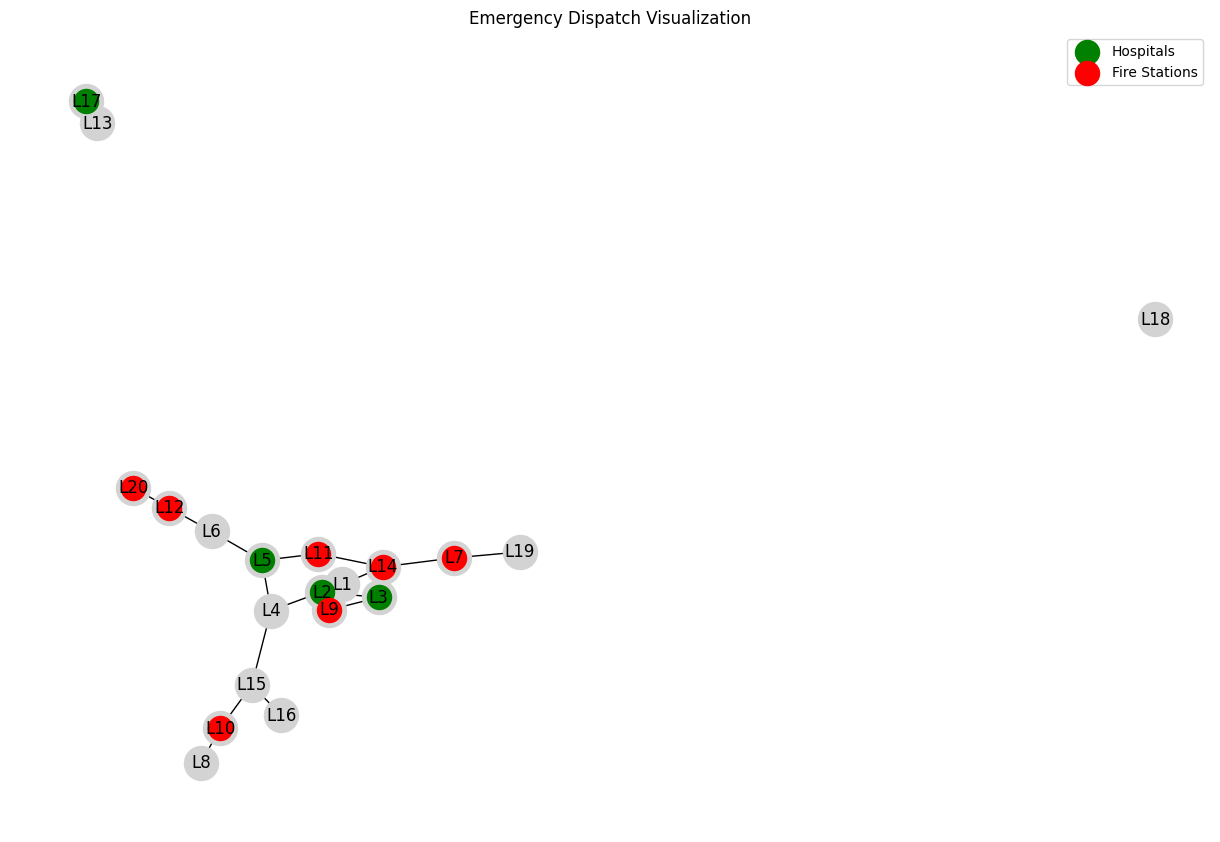

In [49]:
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos, node_size=600, node_color="lightgray", with_labels=True)

# Hospitals
hospitals = facilities[facilities["facility_type"]=="Hospital"]["location_id"]
nx.draw_networkx_nodes(G, pos, nodelist=hospitals, node_color="green", label="Hospitals")

# Fire Stations
firestations = facilities[facilities["facility_type"]=="FireStation"]["location_id"]
nx.draw_networkx_nodes(G, pos, nodelist=firestations, node_color="red", label="Fire Stations")

# Highlight route
if path:
    edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="blue", width=3)

plt.legend()
plt.title("Emergency Dispatch Visualization")
plt.show()

### Part-2 Summary
- Emergency facilities were mapped using hashing.
- Incidents were processed using FIFO and priority queues.
- Best facility selection used Dijkstra and greedy logic.
- MST supported emergency coverage analysis.
- Sorting and DP enabled analytics and optimization.
- Visualizations provided system-level insights.